In [14]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import os
import cv2
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
#from logger import Logger
from torch.utils.data import DataLoader, Dataset
#from RED_CNN_dataloader import DCMsDataset
from skimage.measure import compare_psnr, compare_ssim, compare_nrmse

%matplotlib inline

In [15]:
# RED-CNN
class RED_CNN(nn.Module):
    def __init__(self, out_channels=96):
        super(RED_CNN, self).__init__()
        self.conv_first = nn.Conv2d(1, out_channels, kernel_size=5, stride=1, padding=0)
        self.conv = nn.Conv2d(out_channels, out_channels, kernel_size=5, stride=1, padding=0)
        self.deconv = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=5, stride=1, padding=0)
        self.deconv_last = nn.ConvTranspose2d(out_channels, 1, kernel_size=5, stride=1, padding=0)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Encoder
        residual1 = x # 28*28
        layer01 = self.conv_first(x)
        layer01 = self.relu(layer01)
        residual2 = layer01 # 24*24
        layer02 = self.conv(layer01)
        layer02 = self.relu(layer02)
        residual3 = layer02 # 20*20
        layer03 = self.conv(layer02)
        layer03 = self.relu(layer03)
        residual4 = layer03 # 16*16
        layer04 = self.conv(layer03)
        layer04 = self.relu(layer04)
        residual5 = layer04 # 12*12
        layer05 = self.conv(layer04)
        layer05 = self.relu(layer05) # 8*8
        # Decoder
        layer06 = self.deconv(layer05) # 12*12
        layer06 += residual5
        layer06 = self.relu(layer06)
        layer07 = self.deconv(layer06) # 16*16
        layer07 += residual4
        layer07 = self.relu(layer07)
        layer08 = self.deconv(layer07) # 20*20
        layer08 += residual3
        layer08 = self.relu(layer08)
        layer09 = self.deconv(layer08) # 24*24
        layer09 += residual2
        layer09 = self.relu(layer09)
        layer10 = self.deconv_last(layer09) # 28*28
        layer10 += residual1
        layer10 = self.relu(layer10)
        return layer10

In [16]:
def test_RED_CNN(data_path, num_test, pre_model, figure=None, model=RED_CNN()):

    # model load
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    redcnn = model.to(device)
    redcnn.load_state_dict(torch.load(pre_model))

    # data load
    dir = sorted(os.listdir(data_path))
    test_inputs = []; test_targets = []
    for fname in dir:
        if 'input' in fname:
            test_inputs.append(fname)
        else: test_targets.append(fname)

    random_test = sorted(np.random.randint(len(test_inputs), size=num_test))

    test_img_ori = [np.load(data_path+sorted(test_inputs)[i]) for i in random_test]
    test_img = [torch.Tensor(img).unsqueeze(0).unsqueeze(0) for img in test_img_ori]

    #test_output = []
    #for img in test_img:
    #    red_output = redcnn(img.to(device))
    #    torch.cuda.empty_cache()
    #    test_output.append(red_output)
    test_output =[redcnn(img.to(device)) for img in test_img]
    test_output = [img.squeeze(0).squeeze(0) for img in test_output]
    test_output_img = [img.data.cpu().numpy() for img in test_output]

    test_target = [np.load(data_path+sorted(test_targets)[i]) for i in random_test]

    if figure != None:
        fig = plt.figure(figsize=(40,40))
        i = 0
        for img1, img2, img3 in zip(test_img_ori, test_output_img, test_target):
            for img_ in [img1, img2, img3]:
                fig.add_subplot(len(random_test), 3, i+1)
                plt.imshow(img_, cmap=plt.cm.gray)
                i += 1
                
    return test_img_ori, test_output_img, test_target


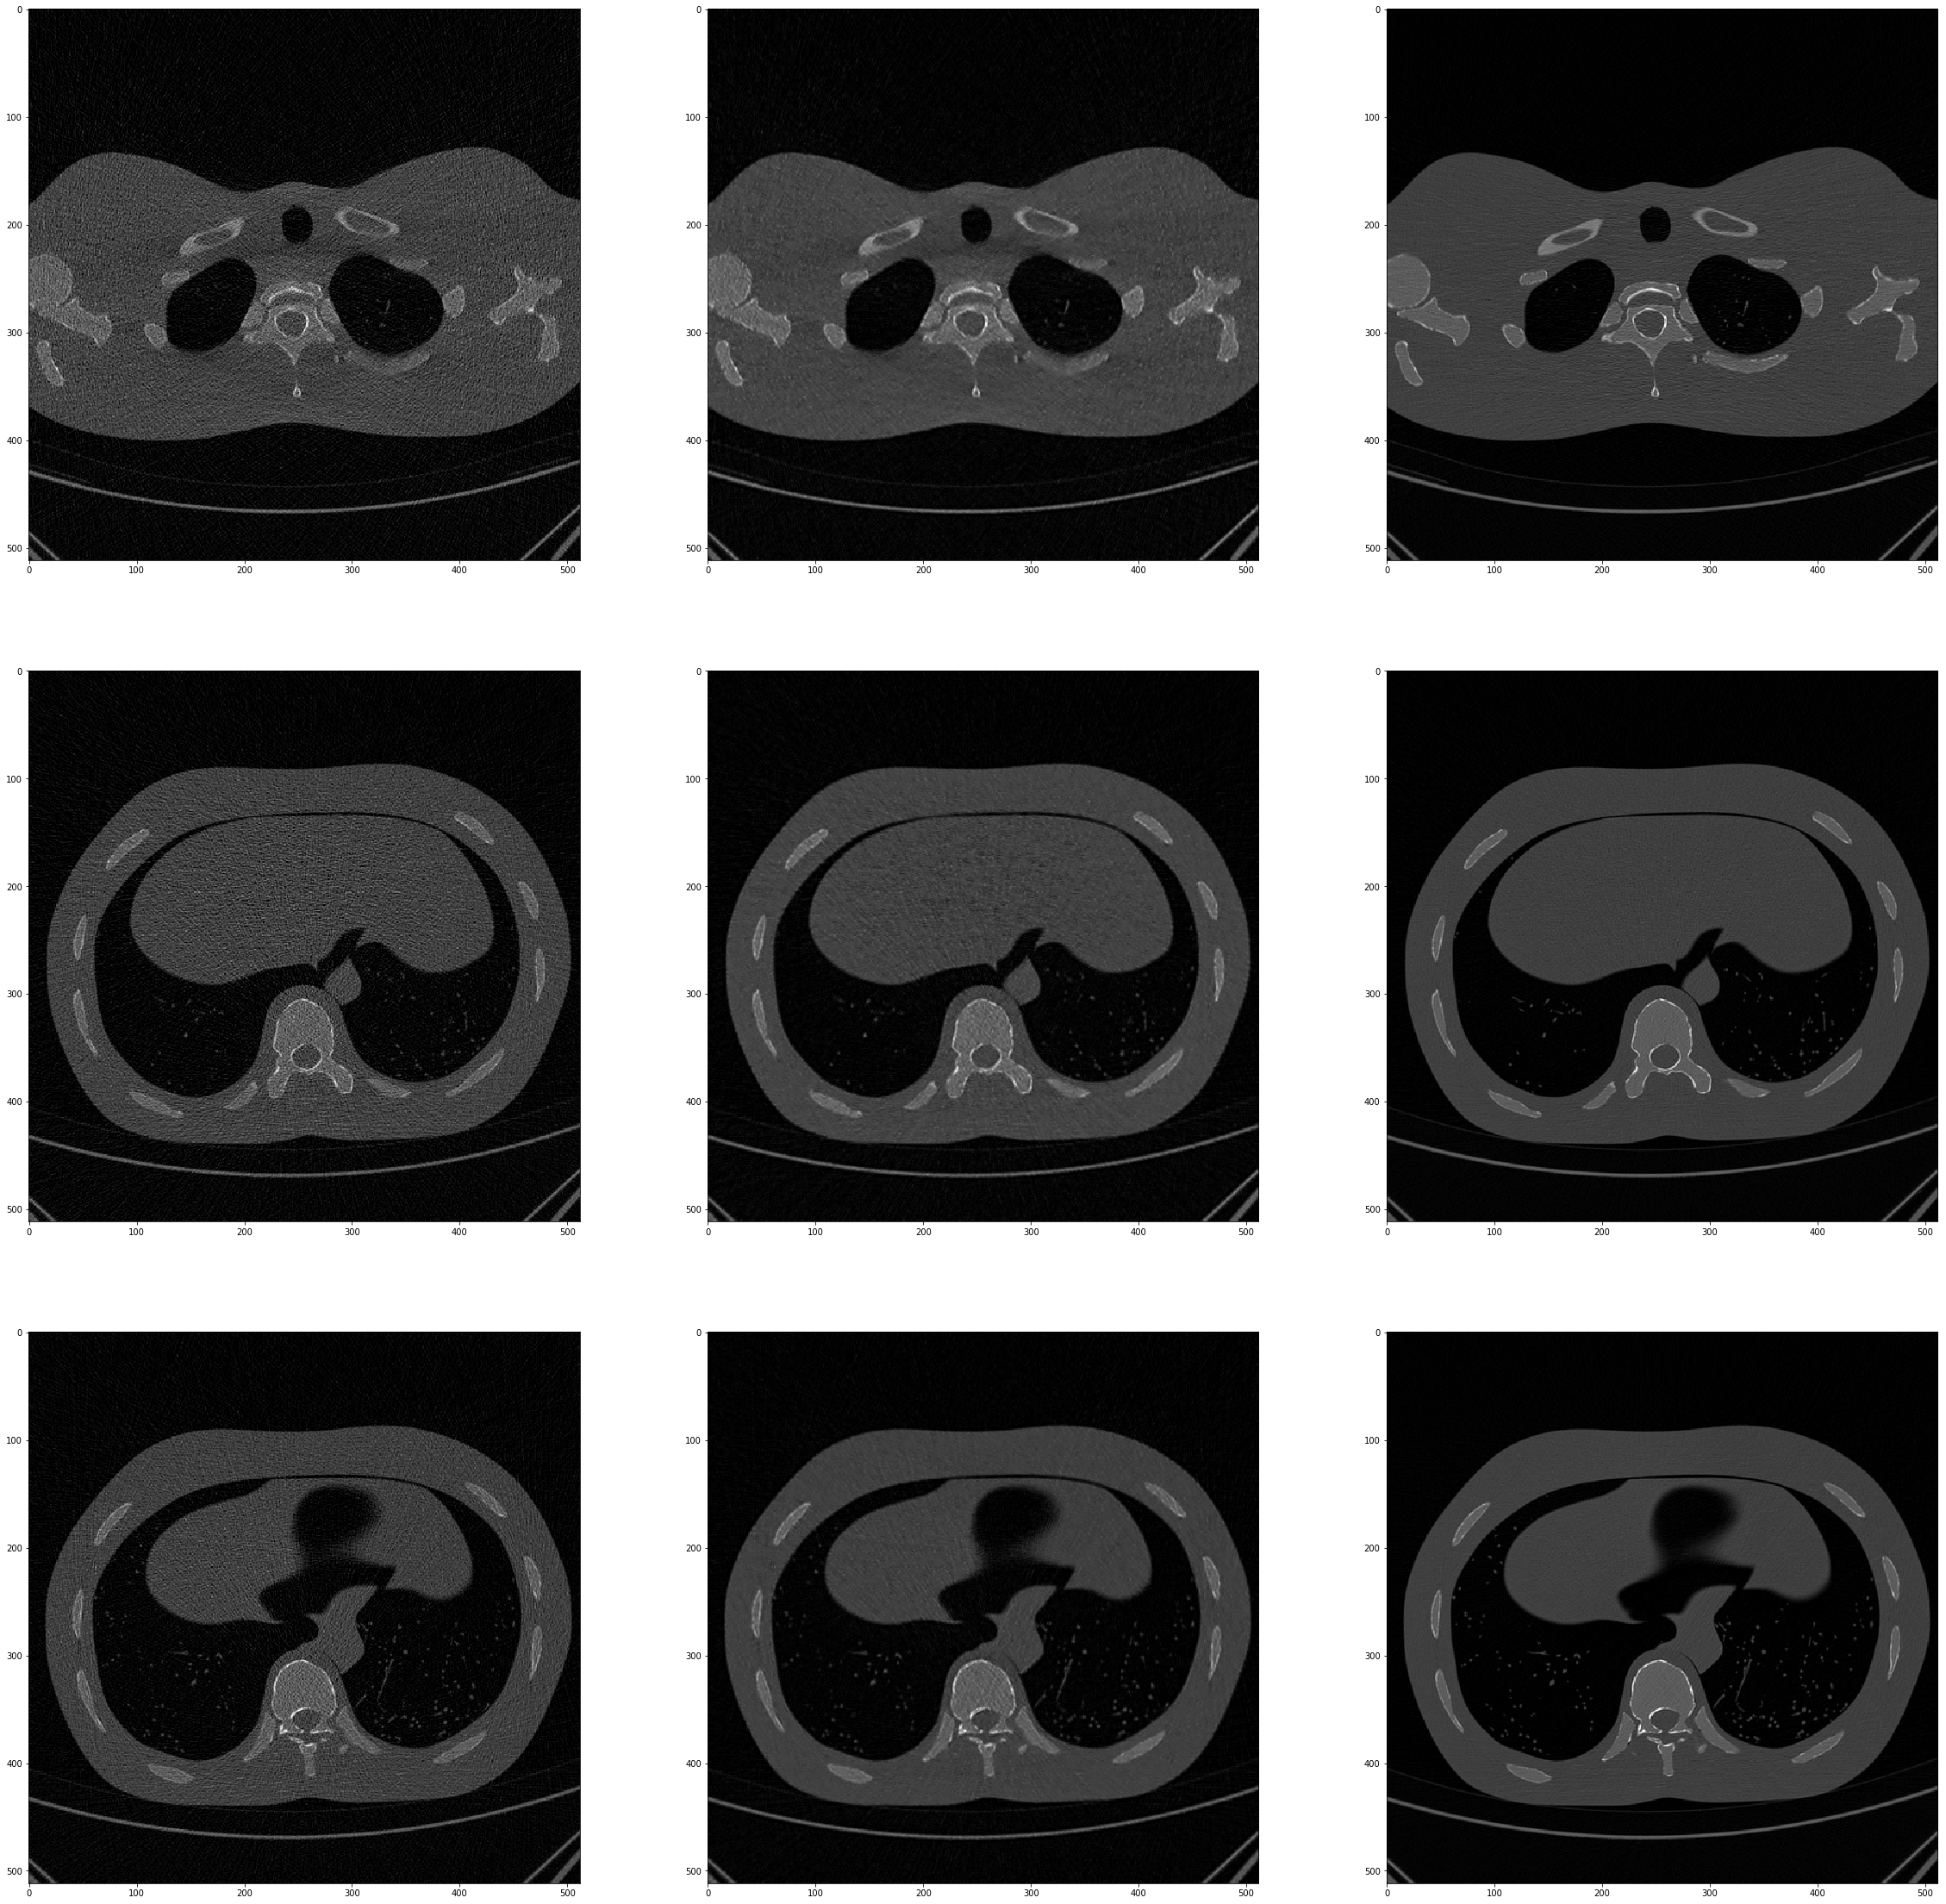

In [22]:
test_path = '/home/datascience/PycharmProjects/CT/dev_image/'
pre_model1 = '/home/datascience/PycharmProjects/CT/redcnn_100ep.ckpt'
%matplotlib inline

original, model_output, target = test_RED_CNN(test_path, 3, pre_model1, figure=2)

In [47]:
from skimage.measure import compare_psnr, compare_ssim, compare_nrmse

def result_(original, model_output, target, measure, all=None, d_range=4096):
    # number of img
    if len(original) == len(model_output) == len(target):
        n_img = len(original)
    else: raise NotImplementedError
    
    # measure = 'psnr' or 'ssim' or 'nrmse'
    if measure not in ['psnr', 'ssim', 'nrmse']:
        raise ValueError
    
    original = np.array(original, dtype=np.float32)
    model_output = np.array(model_output, dtype=np.float32)
    target = np.array(target, dtype=np.float32)
    
    if measure == 'psnr':
        if all == None:
            for i in range(n_img):
                psnr_ori = compare_psnr(original[i], target[i], data_range=d_range)
                psnr_mod = compare_psnr(model_output[i], target[i], data_range=d_range)
                print('img_{}_original_PSNR : {:.4f}'.format(i+1, psnr_ori))
                print('img_{}_model_PSNR : {:.4f}'.format(i+1, psnr_mod))
    
        else:
            psnr_ori = compare_psnr(original, target, data_range=d_range)
            psnr_mod = compare_psnr(model_output, target, data_range=d_range)
            print('img_original_PSNR : {:.4f}'.format(psnr_ori))
            print('img_model_PSNR : {:.4f}'.format(psnr_mod))
    
    if measure == 'ssim':
        ms_ssim_ori = 1
        ms_ssim_mod = 1
        for i in range(n_img):
            ssim_ori = compare_ssim(original[i], target[i], data_range=d_range)
            ssim_mod = compare_ssim(model_output[i], target[i], data_range=d_range)
            ms_ssim_ori *= ssim_ori
            ms_ssim_mod *= ssim_mod
            if all == None:
                print('img_{}_original_SSIM : {:.4f}'.format(i+1, ssim_ori))
                print('img_{}_model_SSIM : {:.4f}'.format(i+1, ssim_mod))
        if all != None:
            print('img_original_SSIM : {:.4f}'.format(ms_ssim_ori))
            print('img_model_SSIM : {:.4f}'.format(ms_ssim_mod))
            

In [53]:
result_(original, model_output, target, measure='psnr', all=1)
print('\n')
result_(original, model_output, target, measure='ssim', all=1)

img_original_PSNR : 25.6898
img_model_PSNR : 30.5521


img_original_SSIM : 0.3955
img_model_SSIM : 0.6715


===

In [8]:
class DCMsDataset(Dataset):
    def __init__(self, input_path, target_path, transfrom=None):
        self.input_path = input_path
        self.target_path = target_path
        self.input_dir = sorted(os.listdir(input_path))
        self.target_dir = sorted(os.listdir(target_path))
        self.transfrom = transfrom

    def __len__(self):
        # input and target have same length
        return len(self.input_dir)

    def __getitem__(self, idx):
        input_name = os.path.join(self.input_path, self.input_dir[idx])
        target_name = os.path.join(self.target_path, self.target_dir[idx])
        input_img = np.load(input_name)
        target_img = np.load(target_name)
        #sample = {'input':input_img, 'target':target_img}
        sample = (input_img, target_img)

        if self.transfrom:
            sample = self.transfrom(sample)

        return sample

In [9]:
class psnr_loss(nn.Module):
    def __init__(self):
        super(psnr_loss, self).__init__()
        
    def forward(self, img1, img2):
        if img1.size()[1] == 1:
            img1 = img1.squeeze(1)
        img1 = img1.data.cpu().numpy()
        if img2.size()[1] == 1:
            img2 = img2.squeeze(1)
        img2 = img2.data.cpu().numpy()
        loss_ = compare_psnr(img1, img2, data_range=4096)
        loss_tensor = torch.zeros(1,)
        loss_tensor[0,] = loss_
        loss = torch.sum(loss_tensor).to(device)
        return 1/loss*10000
    
    def backward():
        # ..?
        pass

In [12]:
LEARNING_RATE = 1e-3
NUM_EPOCHS = 100
BATCH_SIZE = 32
OUT_CHANNELS = 96

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
red_cnn = RED_CNN(96).to(device)
optimizer = torch.optim.Adam(red_cnn.parameters(), lr=0.001)
# patch datasets
input_img_dir = '/home/datascience/PycharmProjects/CT/patch/input/'
target_img_dir = '/home/datascience/PycharmProjects/CT/patch/target/'
#print(os.listdir(input_img_dir)[:3])
#print(os.listdir(target_img_dir)[:3])

dcm = DCMsDataset(input_img_dir, target_img_dir)
dcmloader = DataLoader(dcm, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dcm, batch_size=BATCH_SIZE, shuffle=False)

total_step = len(dcmloader)
current_lr = LEARNING_RATE

for epoch in range(NUM_EPOCHS):
    for i, (inputs, targets) in enumerate(dcmloader):
        input_img = torch.tensor(inputs, requires_grad=True).unsqueeze(1).to(device)
        target_img = torch.tensor(targets).unsqueeze(1).to(device)

                
        outputs = red_cnn(input_img)
        loss = nn.MSELoss()(outputs, target_img) * 0 + psnr_loss()(outputs, target_img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print('EPOCH [{}/{}], STEP [{}/{}], LOSS {:.4f}'.format(epoch+1, NUM_EPOCHS, i+1, total_step, loss.item()))

EPOCH [1/100], STEP [100/4910], LOSS 355.1485
EPOCH [1/100], STEP [200/4910], LOSS 345.5711
EPOCH [1/100], STEP [300/4910], LOSS 397.1581
EPOCH [1/100], STEP [400/4910], LOSS 415.4479
EPOCH [1/100], STEP [500/4910], LOSS 357.7888
EPOCH [1/100], STEP [600/4910], LOSS 383.6424
EPOCH [1/100], STEP [700/4910], LOSS 294.6111


KeyboardInterrupt: 